<a href="https://colab.research.google.com/github/mann718/DL-lab/blob/main/lab%201/lab1_202511046.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#task1
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/fake_reviews_dataset - fake_reviews_dataset.csv")

df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,category,rating,label,text_
1,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor..."
2,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I..."
3,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...
4,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i..."


In [ ]:
df = df.iloc[1:].reset_index(drop=True)

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['Unnamed: 0'])

In [ ]:
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'Books_5': np.int64(0),
 'Clothing_Shoes_and_Jewelry_5': np.int64(1),
 'Electronics_5': np.int64(2),
 'Home_and_Kitchen_5': np.int64(3),
 'Kindle_Store_5': np.int64(4),
 'Movies_and_TV_5': np.int64(5),
 'Pet_Supplies_5': np.int64(6),
 'Sports_and_Outdoors_5': np.int64(7),
 'Tools_and_Home_Improvement_5': np.int64(8),
 'Toys_and_Games_5': np.int64(9)}

In [ ]:
X = df['Unnamed: 3']
y = df['category_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

import pandas as pd
import numpy as np

In [ ]:
num_classes = len(label_encoder.classes_)

In [ ]:
X_train_tensor = torch.tensor(X_train_vec.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_vec.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
train_dataset = ReviewDataset(X_train_tensor, y_train_tensor)
test_dataset = ReviewDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextClassifier(
    input_dim=X_train_tensor.shape[1],
    num_classes=num_classes
).to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.8348
Epoch [2/10], Loss: 0.4514
Epoch [3/10], Loss: 0.3424
Epoch [4/10], Loss: 0.2601
Epoch [5/10], Loss: 0.1874
Epoch [6/10], Loss: 0.1311
Epoch [7/10], Loss: 0.0869
Epoch [8/10], Loss: 0.0578
Epoch [9/10], Loss: 0.0383
Epoch [10/10], Loss: 0.0257


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())


In [ ]:
# task1 results
print("Accuracy:", accuracy_score(all_labels, all_preds))

print(
    classification_report(
        all_labels,
        all_preds,
        target_names=label_encoder.classes_
    )
)

Accuracy: 0.7405712872511439
                              precision    recall  f1-score   support

                     Books_5       0.72      0.72      0.72       874
Clothing_Shoes_and_Jewelry_5       0.80      0.75      0.78       770
               Electronics_5       0.78      0.78      0.78       798
          Home_and_Kitchen_5       0.61      0.67      0.64       811
              Kindle_Store_5       0.76      0.76      0.76       946
             Movies_and_TV_5       0.91      0.85      0.88       717
              Pet_Supplies_5       0.83      0.82      0.83       851
       Sports_and_Outdoors_5       0.58      0.60      0.59       789
Tools_and_Home_Improvement_5       0.66      0.66      0.66       772
            Toys_and_Games_5       0.79      0.80      0.80       759

                    accuracy                           0.74      8087
                   macro avg       0.74      0.74      0.74      8087
                weighted avg       0.74      0.74      0.74

In [ ]:
# task2

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,category_encoded
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor...",3
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I...",3
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...,3
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i...",3
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...,3


In [ ]:
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'CG': np.int64(0), 'OR': np.int64(1)}

In [ ]:
label_encoder = LabelEncoder()
df['fake_encoded'] = label_encoder.fit_transform(df['Unnamed: 2'])

In [ ]:
X = df['Unnamed: 3']
y = df['fake_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

In [ ]:
num_classes = len(label_encoder.classes_)

In [ ]:
X_train_tensor = torch.tensor(X_train_vec.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_vec.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
train_dataset = ReviewDataset(X_train_tensor, y_train_tensor)
test_dataset = ReviewDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextClassifier(
    input_dim=X_train_tensor.shape[1],
    num_classes=num_classes
).to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.3101
Epoch [2/10], Loss: 0.2023
Epoch [3/10], Loss: 0.1451
Epoch [4/10], Loss: 0.0913
Epoch [5/10], Loss: 0.0461
Epoch [6/10], Loss: 0.0218
Epoch [7/10], Loss: 0.0104
Epoch [8/10], Loss: 0.0056
Epoch [9/10], Loss: 0.0047
Epoch [10/10], Loss: 0.0028


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())


In [ ]:
# task2 results
print("Accuracy:", accuracy_score(all_labels, all_preds))

print(
    classification_report(
        all_labels,
        all_preds,
        target_names=label_encoder.classes_
    )
)


Accuracy: 0.8791888215654755
              precision    recall  f1-score   support

          CG       0.87      0.89      0.88      4044
          OR       0.88      0.87      0.88      4043

    accuracy                           0.88      8087
   macro avg       0.88      0.88      0.88      8087
weighted avg       0.88      0.88      0.88      8087



In [ ]:
#task3
!pip install wordcloud


In [ ]:
!pip install nltk


In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
default_stopwords = set(stopwords.words('english'))

custom_stopwords = {
    'said', 'news', 'report', 'reports', 'people',
    'one', 'two', 'also', 'would', 'could',
    'say', 'says', 'according', 'via', 'new',
    'year', 'time', 'government', 'today'
}

all_stopwords = default_stopwords.union(custom_stopwords)

In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)   # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)         # remove numbers & punctuation
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [ ]:
df['clean_text'] = df['Unnamed: 3'].apply(clean_text)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud


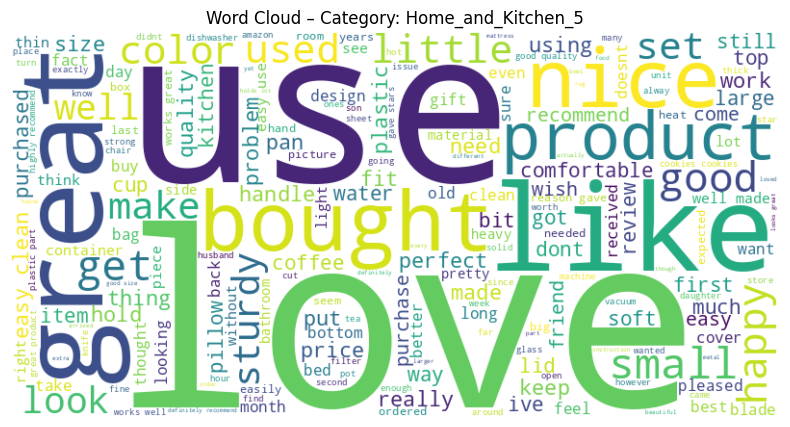

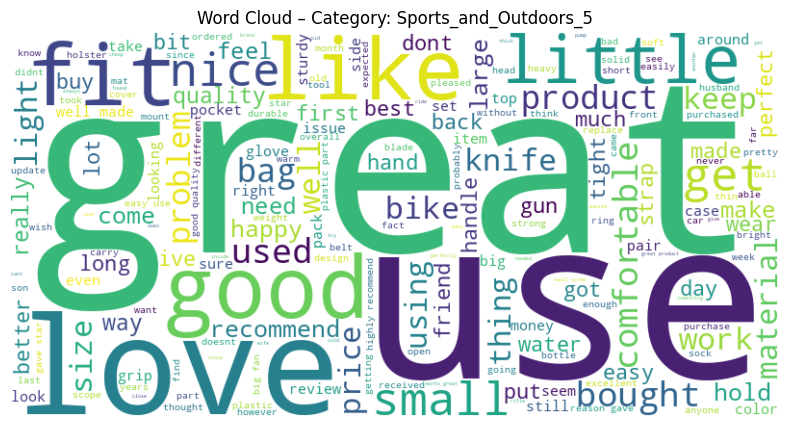

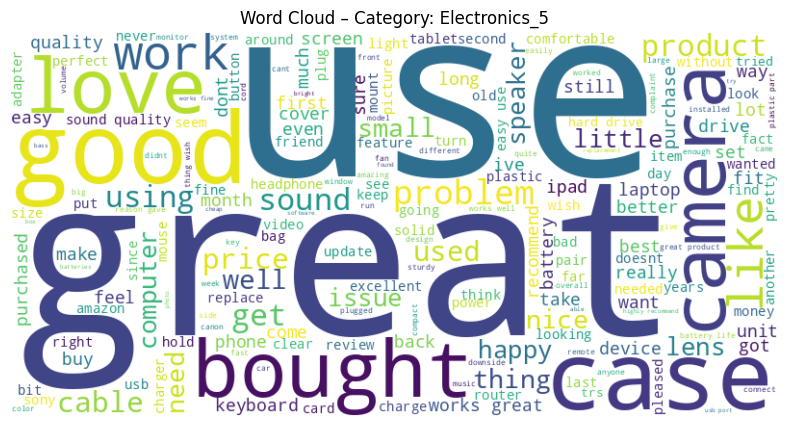

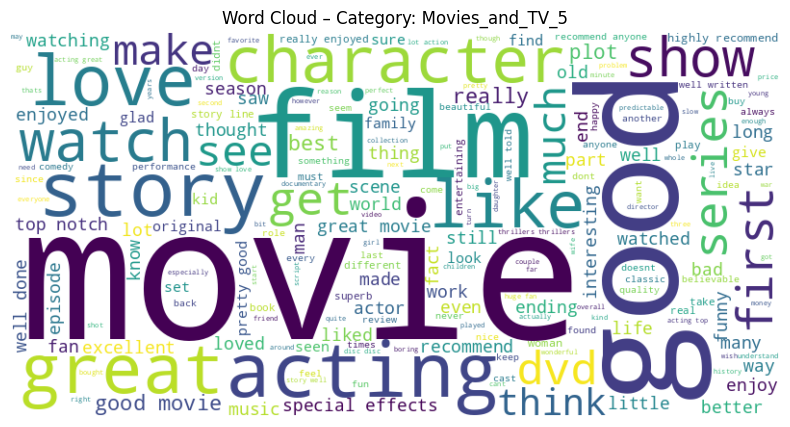

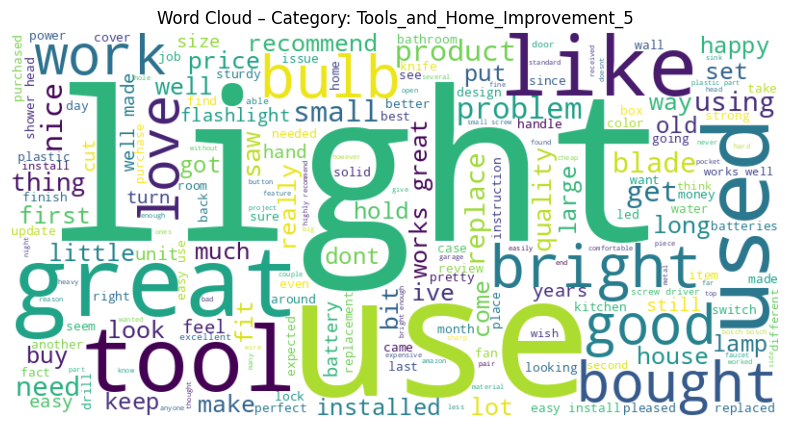

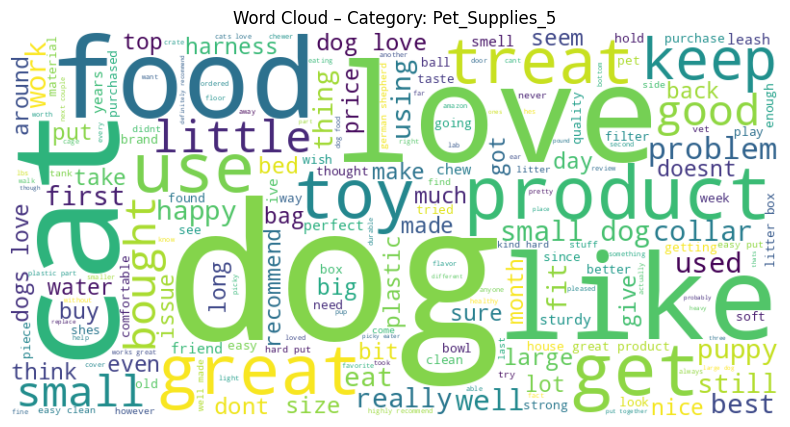

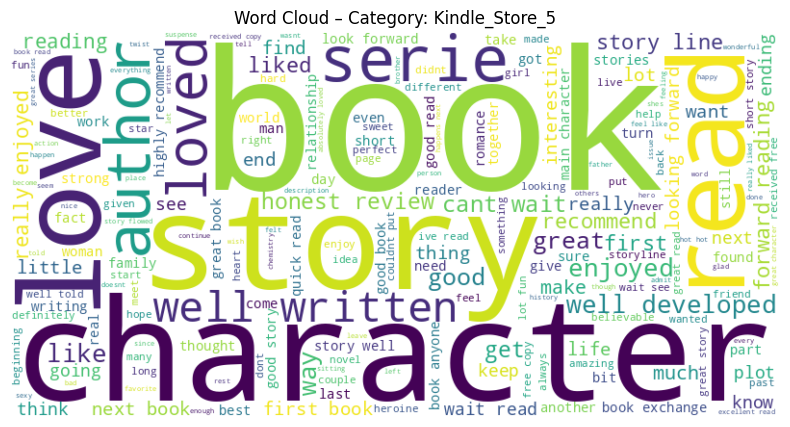

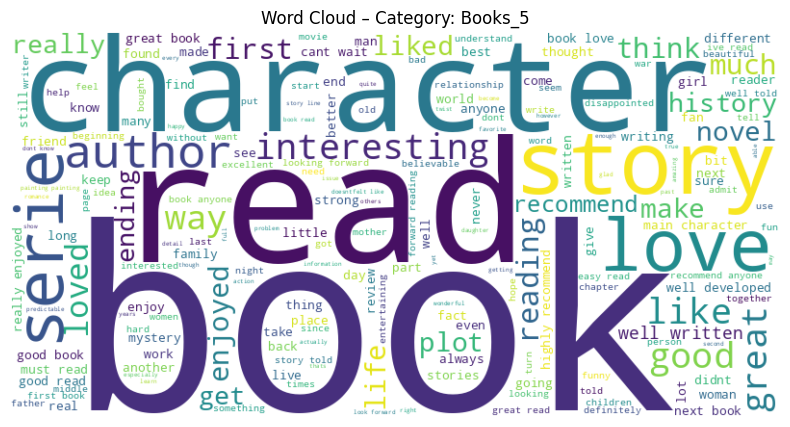

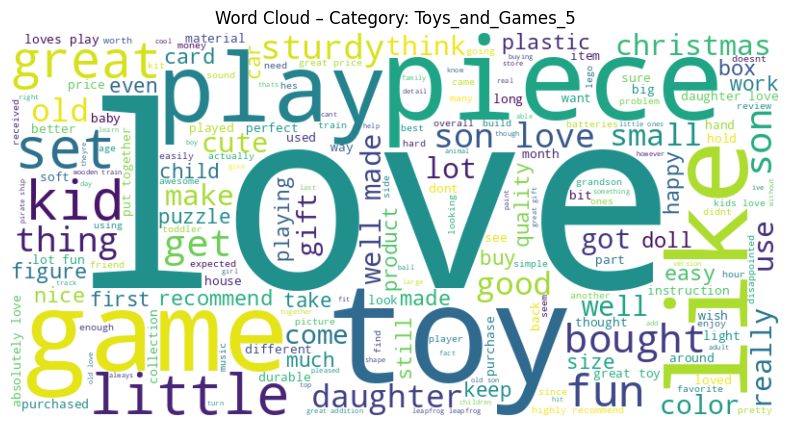

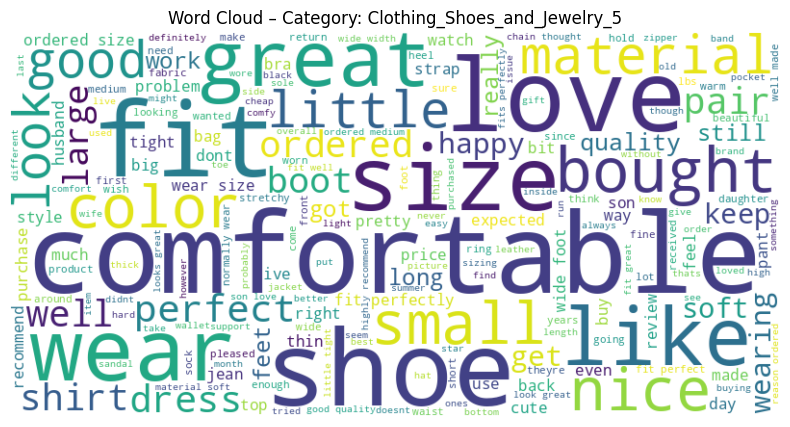

In [ ]:
# task3 results
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for category in df['Unnamed: 0'].unique():
    text = " ".join(
        df[df['Unnamed: 0'] == category]['clean_text']
    )

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=all_stopwords,
        min_word_length=3,   # removes short junk
        max_words=200
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud – Category: {category}")
    plt.show()
